In [1]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [2]:

# Fetch environment variables with a fallback to avoid None errors
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING")

# Set environment variables
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY
os.environ["LANGSMITH_PROJECT"] = LANGSMITH_PROJECT
os.environ["LANGSMITH_ENDPOINT"] = LANGSMITH_ENDPOINT
os.environ["LANGSMITH_TRACING"] = LANGSMITH_TRACING


In [3]:
from langchain_community.tools import TavilySearchResults

In [4]:
tavily_tool = TavilySearchResults(max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True)

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

c:\Users\HP\Desktop\LangGraph\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from langchain_core.tools import tool

In [7]:
@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    response = tavily_tool.invoke(prompt)
    return response

In [8]:
tools = [get_city_details]

In [9]:
model_with_tools = llm.bind_tools(tools)

In [10]:
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState,StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of the city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")

In [11]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: CityDetails

In [12]:

model_with_structured_output = llm.with_structured_output(CityDetails)

In [13]:
def call_model(state: AgentState):
    print(f" this is 01 input from call model {state}")
    response = model_with_tools.invoke(state['messages'])
    print(f"this is 02 response from call model  {response}")
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [14]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue with the tool
    else:
        return "continue"

In [15]:
def respond(state: AgentState):
    print(f"here is 03 state from respond {state}")
    response = model_with_structured_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    # We return the final answer
    print(f"this is 04 response from respond{response}")
    return {"final_response": response}

In [16]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("llm", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)


# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("llm")

# We now add a conditional edge
workflow.add_conditional_edges(
    "llm",
    
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "llm")
workflow.add_edge("respond", END)
graph = workflow.compile()

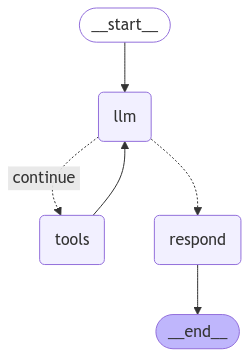

In [17]:
from IPython.display import Image, display
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
answer = graph.invoke(input={"messages": [("human", "Tell me about the city details for gwalior?")]})['final_response']


 this is 01 input from call model {'messages': [HumanMessage(content='Tell me about the city details for gwalior?', additional_kwargs={}, response_metadata={}, id='ee982aef-f2de-4e88-8e6d-28a232f664a4')]}


ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[prompt].type: must be specified when not using one_of
